In [30]:
# Reference sources outside the Learning from Data course:
# https://prappleizer.github.io/Tutorials/MCMC/MCMC_Tutorial.html
# https://emcee.readthedocs.io/en/stable/tutorials/line/
# for backend: https://emcee.readthedocs.io/en/stable/tutorials/monitor/

import numpy as np
import scipy as scipy
import matplotlib
import matplotlib.pyplot as plt
import emcee
import corner
import pandas as pd
#import h5py
%matplotlib inline
plt.rcParams['figure.figsize'] = (15,7)
matplotlib.rcParams.update({
    "text.usetex": True,
    "font.family": "serif", 
    "font.serif" : ["Computer Modern Roman"]
    })

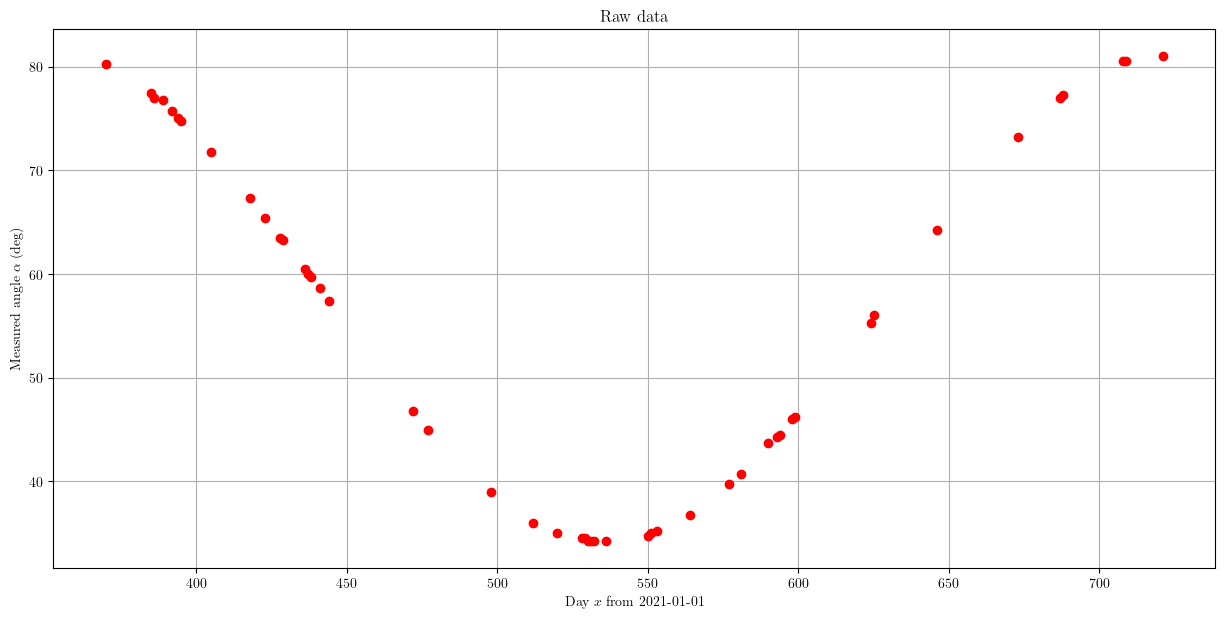

In [168]:
# DATA AND FITTED CURVE #

formatted_CSV_path = "Formatted CSV/SVM_PlotData_from_2022-01-01_to_2022-12-31.csv"
# SVM_PlotData_from_2021-01-01_to_2022-12-23.csv
CSV = pd.read_csv(formatted_CSV_path, sep=',')
CSV = CSV.dropna() #otherwise emcee gets sad

"""
    day:            days from 2021 
    measured_data:  max angle that day
    sigma:          standard deviation of measurement
    fitted_curve:   function of theta and x
"""
header = CSV.columns.values
day = np.array(CSV[header[3]])
measured_data = np.array(CSV[header[4]])
sigma = np.array(CSV[header[5]]) #the uncertainty in the measurements is +-0.25 deg # TODO: perhaps can do this better or more rigorously=

# Parameter values for prior
theta_labels = ["$a$", "$b$", "$c$", "$d$"]
a_min, a_max = 0, 90 # a \in [0, 90] for latitude (from the stars I can tell that I'm on the northen hemisphere)
b_min, b_max = 0, 90 # b \in [0, 90] for the Earths axial tilt (could take 0, 180) but that would be equivalent with having the hemispheres shifted
c_min, c_max = 350, 380 # c is number of days in a year
d_min, d_max = -180, 180 # d is number of days in shift

c_mu, c_sigma = 365.25, 1.0 # c is number of days in a year
d_mu, d_sigma = 11.0, 2.0 # d is number of days in shift

# Check that raw data looks good
plt.title("Raw data")
plt.errorbar(day, measured_data, yerr=sigma, color='r', marker='o', linestyle='')
plt.xlabel("Day $x$ from 2021-01-01")
plt.ylabel("Measured angle $\\alpha$ (deg)")
plt.grid()

In [182]:
# FUNCTIONS #

def calculate_fitted_curve(theta, day):
    a, b, c, d = theta

    # a latitude (in degrees)
    # b Earth's axial tilt (in degrees)
    # c days in a year (periodicity of solar angle) (in days) 
    # d phase - difference between solar year and human year (in days)
    return a + b*np.cos(2*np.pi*(day+d)/c)

def log_prior_flat(theta, theta_max):
    any_parameter_outside_flat_prior = 0
    for i in range(len(theta)):
        if theta[i] >= theta_min[i] and theta[i] <= theta_max[i]:
            continue
        else:
            any_parameter_outside_flat_prior = 1
 
    if any_parameter_outside_flat_prior == 0:
        return 0 # log(1)
    else:
        return -np.inf  # log(0)
    
def log_prior_uniform(theta_i, theta_i_min, theta_i_max):
    if (theta_i_min <= theta_i) and (theta_i <= theta_i_max):
        return 0
    else:
        return -np.inf

def log_prior_Gaussian(theta_i, mu, sigma):
    return -np.log(sigma) - 0.5*np.log(2*np.pi) - (theta_i - mu)**2 / (2 * sigma**2)

def log_likelihood(theta, day, measured_data, sigma):

    log_likelihood = 0
    for i in range(len(day)):
        fitted_curve_value = calculate_fitted_curve(theta, day[i])
        log_likelihood += -(1/2) * (fitted_curve_value - measured_data[i])**2 / sigma[i]**2 #log of likelihood is sum of chi^2-terms 
    
    return log_likelihood

def log_posterior(theta, day, measured_data, sigma):
    log_prior_a = log_prior_uniform(theta[0], a_min, a_max)
    log_prior_b = log_prior_uniform(theta[1], b_min, b_max)
    #log_prior_c = log_prior_uniform(theta[2], c_min, c_max)
    #log_prior_d = log_prior_uniform(theta[3], d_min, d_max)

    log_prior_c = log_prior_Gaussian(theta[2], c_mu, c_sigma)
    log_prior_d = log_prior_Gaussian(theta[3], d_mu, d_sigma)

    log_prior = log_prior_a + log_prior_b + log_prior_c + log_prior_d

    return log_likelihood(theta, day, measured_data, sigma) + log_prior

def run_MCMC(starting_position_walkers, number_of_walkers, number_of_dimensions, number_of_burn_in_steps, number_of_production_steps, data, log_posterior):#, backend):
    sampler = emcee.EnsembleSampler(number_of_walkers, number_of_dimensions, log_posterior, args=data)#, backend=backend)
    print("MCMC sampling")
    print("Running: burn-in")
    pos_burn_in, prob_burn_in, state_burn_in = sampler.run_mcmc(starting_position_walkers, number_of_burn_in_steps)
    sampler.reset()

    print("Running: production")
    pos_production, prob_production, state_production = sampler.run_mcmc(pos_burn_in, number_of_production_steps)#, store=True)

    return sampler, pos_burn_in, prob_burn_in, state_burn_in, pos_production, prob_production, state_production

In [183]:
# Preparations to run MCMC #

data = [day, measured_data, sigma]
initial_theta = np.array([60, 25, 365, 0]) #initial parameter guess to help MCMC be faster

number_of_walkers = 20
number_of_burn_in_steps = 1000
number_of_production_steps = 5000
number_of_dimensions = len(initial_theta)
MCMC_filename = f"MCMC_walkers{number_of_walkers}_burninsteps{number_of_burn_in_steps}_productionsteps{number_of_production_steps}"
# Setup backend to save data to file
backend = emcee.backends.HDFBackend(f"MCMC data/{MCMC_filename}.h5")
backend.reset(number_of_walkers, number_of_dimensions)

# Randomize starting positions
starting_position_walkers = np.array(initial_theta) + np.random.rand(number_of_walkers, number_of_dimensions)


In [184]:
# RUN MCMC #
sampler, pos_burn_in, prob_burn_in, state_burn_in, pos_production, prob_production, state_production = run_MCMC(starting_position_walkers, number_of_walkers, number_of_dimensions, number_of_burn_in_steps, number_of_production_steps, data, log_posterior)#, backend)

MCMC sampling
Running: burn-in
Running: production


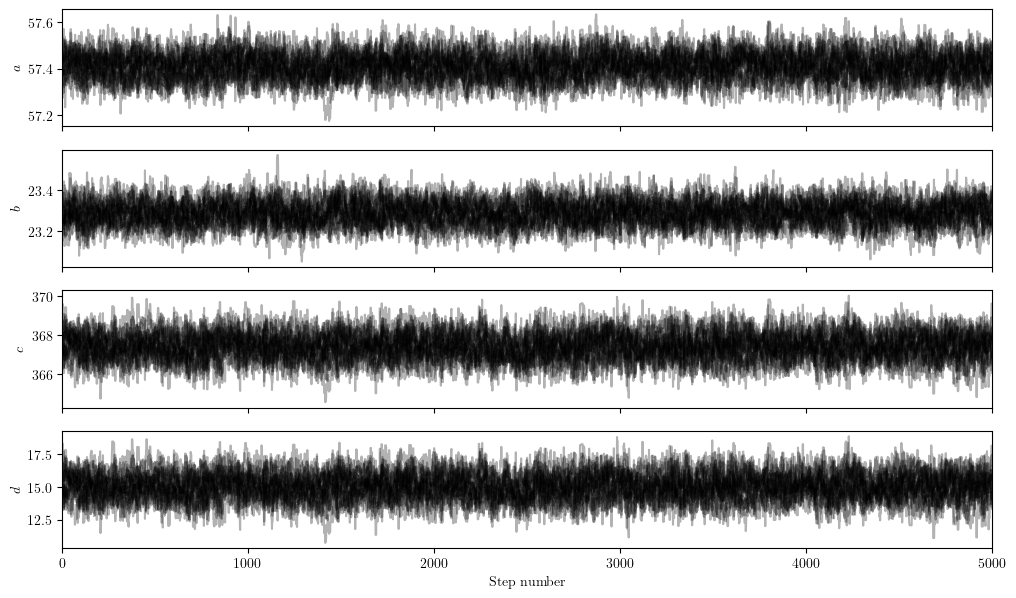

In [185]:
# PARAMETER AS FUNCTION OF STEP #

reader_filename = MCMC_filename#"MCMC_walkers40_burninsteps1000_productionsteps50000"
#reader = emcee.backends.HDFBackend(f"MCMC data/{reader_filename}.h5", read_only=True)
#samples = reader.get_chain()
samples = sampler.get_chain() # shape: (number_of_iterations, number_of_walkers, len(theta))

fig, axes = plt.subplots(number_of_dimensions, figsize=(12, 7), sharex=True)
for i in range(number_of_dimensions):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(theta_labels[i])
 
axes[-1].set_xlabel("Step number")
fig.savefig(f"MCMC figures/theta_vs_step_number_{reader_filename}.pdf")
#tau = sampler.get_autocorr_time()
#print(f"Autocorrelation time (steps): {tau}")

len(flat_samples) = 100000


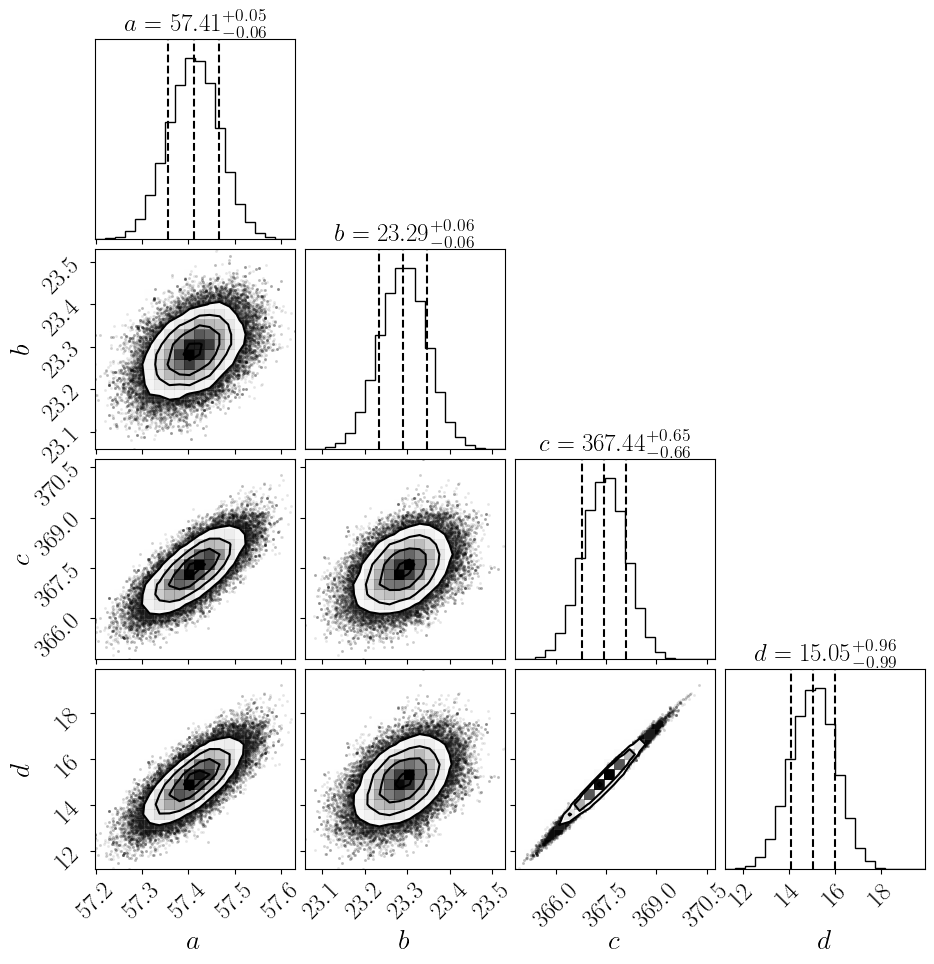

In [180]:
# TODO: plotta burn in, see convergence
# TODO: mer

#flat_samples = reader.get_chain(flat=True)
flat_samples = sampler.get_chain(flat=True)
print(f"len(flat_samples) = {len(flat_samples)}")
#sampled_parameter_values = flat_samples[np.argmax(reader.flatlnprobability)]
#print(sampled_parameter_values)

fig = corner.corner(flat_samples,
                    show_titles=True,
                    #plot_datapoints=True,
                    labels=theta_labels,
                    quantiles=[0.16, 0.5, 0.84], 
                    title_kwargs={"fontsize": 18},
                    label_kwargs={"fontsize": 20},)

# Styling
for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=18)
    
fig.savefig(f"MCMC figures/corner_{reader_filename}.pdf")

MAP parameter value (+1sigma, -1sigma) (+2sigma, -2sigma)
theta[0]: 57.411 (+0.054, -0.056) (+0.092, -0.094)
theta[1]: 23.291 (+0.055, -0.057) (+0.094, -0.097)
theta[2]: 367.442 (+0.647, -0.664) (+1.092, -1.133)
theta[3]: 15.051 (+0.957, -0.986) (+1.623, -1.664)


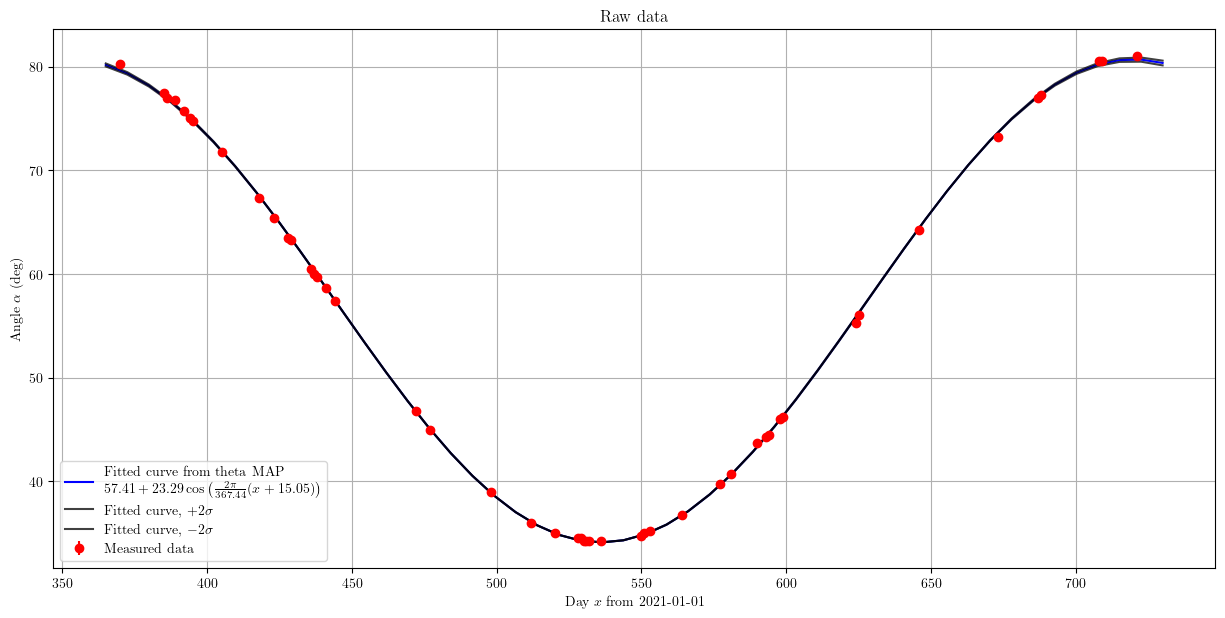

In [181]:
# GET THETA THAT MAXIMIZES POSTERIOR PROBABILITY #
theta_MAP, theta_MAP_plus_one_sigma, theta_MAP_minus_one_sigma, theta_MAP_plus_two_sigma, theta_MAP_minus_two_sigma = [], [], [], [], []

print("MAP parameter value (+1sigma, -1sigma) (+2sigma, -2sigma)")
for i in range(number_of_dimensions):
    theta_MAP.append(np.percentile(flat_samples[:, i], [50]))
    theta_MAP_plus_one_sigma.append(np.percentile(flat_samples[:,i], [84]))
    theta_MAP_minus_one_sigma.append(np.percentile(flat_samples[:,i], [16]))
    theta_MAP_plus_two_sigma.append(np.percentile(flat_samples[:,i], [95.45]))
    theta_MAP_minus_two_sigma.append(np.percentile(flat_samples[:,i], [4.55]))
    string = "theta[%.0d]: %.3f (+%.3f, -%.3f) (+%.3f, -%.3f)" % (i, theta_MAP[i], theta_MAP_plus_one_sigma[i]-theta_MAP[i], theta_MAP[i]-theta_MAP_minus_one_sigma[i], theta_MAP_plus_two_sigma[i]-theta_MAP[i], theta_MAP[i]-theta_MAP_minus_two_sigma[i])
    print(string)


days_linspace = np.linspace(365, 2*365)
fitted_curve_theta_MAP = calculate_fitted_curve(theta_MAP, days_linspace)
fitted_curve_theta_MAP_plus_one_sigma  = calculate_fitted_curve(theta_MAP_plus_one_sigma, days_linspace)
fitted_curve_theta_MAP_minus_one_sigma = calculate_fitted_curve(theta_MAP_minus_one_sigma, days_linspace)
fitted_curve_theta_MAP_plus_two_sigma  = calculate_fitted_curve(theta_MAP_plus_two_sigma, days_linspace)
fitted_curve_theta_MAP_minus_two_sigma = calculate_fitted_curve(theta_MAP_minus_two_sigma, days_linspace)

fitted_curve_label = "Fitted curve from theta MAP\n$%.2f + %.2f\\cos\\left(\\frac{2\\pi}{%.2f}(x+%.2f)\\right)$" % (theta_MAP[0], theta_MAP[1], theta_MAP[2], theta_MAP[3])
plt.title("Raw data")
plt.errorbar(day, measured_data, yerr=sigma, color='r', marker='o', linestyle='', label='Measured data')
plt.plot(days_linspace, fitted_curve_theta_MAP, color='b', label=fitted_curve_label)
plt.plot(days_linspace, fitted_curve_theta_MAP_plus_two_sigma, color='k', alpha=0.75, label='Fitted curve, $+2\\sigma$')
plt.plot(days_linspace, fitted_curve_theta_MAP_minus_two_sigma, color='k', alpha=0.75, label='Fitted curve, $-2\\sigma$')
plt.xlabel("Day $x$ from 2021-01-01")
plt.ylabel("Angle $\\alpha$ (deg)")
plt.legend()
plt.grid()